In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/RI/RI_parole_model_inputs.yaml')
test_sim.data_dict['transitions_data'].loc[test_sim.data_dict['transitions_data'].compartment == 'prison_technical', 'outflow_to'] = 'release'
# test_sim.simulate_baseline(['parole', 'prison_technical', 'prison_new_offense'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 144 results
transitions_data returned 20 results
total_population_data returned 144 results


In [25]:
test_sim.data_dict['transitions_data']

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,RI_parole,5.6,parole,prison_new_offense,0.033,None,misdemeanor,None,None,2021-01-13 17:53:23.852532+00:00
1,RI_parole,5.6,parole,prison_technical,0.065,None,misdemeanor,None,None,2021-01-13 17:53:23.852532+00:00
2,RI_parole,5.6,parole,release,0.902,None,misdemeanor,None,None,2021-01-13 17:53:23.852532+00:00
3,RI_parole,12.0,parole,prison_new_offense,0.065,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
4,RI_parole,24.0,parole,prison_new_offense,0.061,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
5,RI_parole,36.0,parole,prison_new_offense,0.057,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
6,RI_parole,12.0,parole,prison_technical,0.130,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
7,RI_parole,24.0,parole,prison_technical,0.113,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
8,RI_parole,36.0,parole,prison_technical,0.098,None,felony,None,None,2021-01-13 17:53:23.852532+00:00
9,RI_parole,23.0,parole,release,0.477,None,felony,None,None,2021-01-13 17:53:23.852532+00:00


initialization time:  28.231313228607178
simulation_time:  20.670467853546143
initialization time:  29.328441858291626
simulation_time:  20.87553095817566


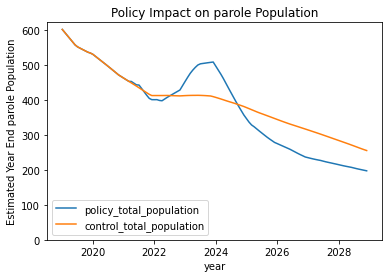

In [6]:
# Policy Option Methods

CURRENT_TIS_PERCENTAGE = 0.768
AFFECTED_PRESUMPTIVE_PAROLE_FRACTION = 1
GOOD_TIME_DAYS_BACK_PER_MONTH = 17
GOOD_TIME_PARTIPICATION_RATE = 1
SIMPLE_TECHNICAL_REVOCATION_FRACTION = 1

def presumptive_parole(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction,
                   reduction_df = pd.DataFrame({'outflow': ['parole', 'release'], 
                                                'reduction_size': [1 - 0.33/CURRENT_TIS_PERCENTAGE] * 2,
                                                'affected_fraction': [AFFECTED_PRESUMPTIVE_PAROLE_FRACTION] * 2}),
                   reduction_type='*',
                   retroactive=retroactive)


def good_time_credits(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction,
                   reduction_df = pd.DataFrame({'outflow': ['release'], 
                                                'reduction_size': [1 - 30/(30 + GOOD_TIME_DAYS_BACK_PER_MONTH)],
                                                'affected_fraction': [GOOD_TIME_PARTIPICATION_RATE]}),
                   reduction_type='*',
                   retroactive=retroactive)

def simple_technical_revocations(retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow,
                   reallocation_df=pd.DataFrame({'outflow': ['prison_technical'], 
                                                 'affected_fraction': [SIMPLE_TECHNICAL_REVOCATION_FRACTION], 
                                                 'new_outflow': ['release']}),
                   reallocation_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [SparkPolicy(policy_fn=simple_technical_revocations(False),
                                           spark_compartment='parole',
                                           sub_population={'crime_type': 'misdemeanor'},
                                           apply_retroactive=False),
                               SparkPolicy(policy_fn=good_time_credits(False),
                                           spark_compartment='parole',
                                           sub_population={'crime_type': 'misdemeanor'},
                                           apply_retroactive=False),
                               SparkPolicy(policy_fn=good_time_credits(False),
                                           spark_compartment='parole',
                                           sub_population={'crime_type': 'felony'},
                                           apply_retroactive=False),
                               SparkPolicy(policy_fn=presumptive_parole(False),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'misdemeanor'},
                                           apply_retroactive=False),
                               SparkPolicy(policy_fn=presumptive_parole(False),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'felony'},
                                           apply_retroactive=False)
                              ]



    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'parole')

In [7]:
simulation_tag = 'RI_parole'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)